In [1]:
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.stats import poisson
import math
from collections import defaultdict
from tqdm import tqdm  # for progress bar

plt.rcParams['figure.dpi'] = 100

## Defining the Parameters

In [2]:
N = 200 # number of nodes 200
Q = 4 # number of groups
q = 50 # group size 50
mu = 0.025 # outside connections (Mxing parameter)
beta = 0.4 # infection rate
r = 1 # recovery rate
k_avg = 3 # average degree 

### Assigning Communities

In [3]:
commu_names = [ _ for _ in range(1,(Q+1))] # name of the communities
G = nx.Graph()
for i in range(N): # assigning the communities as attributes to the graph
    G.add_node(i, community =  math.floor(i/q) + 1)


## Community Structure

### Stochastic-Block Model (SBM)

In [4]:
def create_SBM(G, Q, q, mu, k_avg):
    G_copy = G.copy()
    p_in = k_avg*(1-mu)/(q-1) # probability of interactions within a group
    p_out = k_avg*mu/(N-q) # probability of interactions with nodes outside of its own group

    for i in G_copy:
        groupmates = [node for node, attrs in G_copy.nodes(data=True) if attrs.get('community') == math.floor(i/q)+1 and node != i]
        outsiders = [node for node, attrs in G_copy.nodes(data=True) if attrs.get('community') != math.floor(i/q)+1 ]
        for neighbor in groupmates: 
            if np.random.rand() < p_in:
                G_copy.add_edge(i, neighbor)
        for outsider in outsiders:
            if np.random.rand() < p_out:
                G_copy.add_edge(i, outsider)
    return G_copy




## Measuring Correlation Among the Community Structures of the Layers

##### Maximally Correlated Communities

In [5]:
# Normalized Mutual Information (NMI) = 1
G1 = create_SBM(G, Q, q, mu, k_avg)
G2 = create_SBM(G, Q, q, mu, k_avg)
G1_NMI1 = G1
G2_NMI1 = G2

##### Un-Correlated Communities

In [38]:
# NMI = 0

def swapping_communities(G, r):
    G_copy = G.copy()
    nodes = list(G_copy.nodes())
    np.random.shuffle(nodes)
    while nodes:
        current_node = nodes.pop()
        outsiders = [node for node in nodes if G_copy.nodes[node]["community"] != G_copy.nodes[current_node]["community"]]
        
        if not outsiders:
            continue

        swap_candidate = np.random.choice(outsiders)

        if np.random.rand() < r:
            G_copy.nodes[current_node]["community"] , G_copy.nodes[swap_candidate]["community"] = \
            G_copy.nodes[swap_candidate]["community"] , G_copy.nodes[current_node]["community"]
            nodes.remove(swap_candidate)

    return G_copy

In [39]:
r = 1 # the probablity of swapping edges 
# community_membership_layer2 = community_membership_layer1
# G1 = create_SBM(G, Q, q, mu, k_avg)
G3 = swapping_communities(G, r)
G3 = create_SBM(G3, Q, q, mu, k_avg)
# G1_NMI0 = G1
G2_NMI0 = G3

##### Plot 

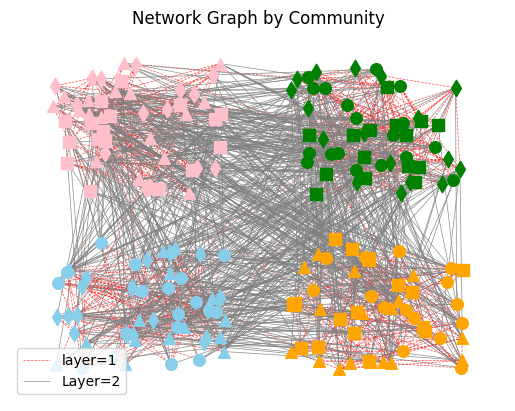

<Figure size 600x600 with 0 Axes>

In [18]:
def custom_layout_by_community_attribute(G, frame_size=(1, 1), padding=0.1, inner_padding=0.05):
    positions = {}
    width, height = frame_size
    communities = set(nx.get_node_attributes(G, 'community').values())  # Extract unique community IDs
    num_communities = len(communities)
    sqrt_num = int(np.ceil(np.sqrt(num_communities)))  # Arrange in a square layout
    community_size = (width - 2 * padding) / sqrt_num
    
    for community_id in communities:
        i = list(communities).index(community_id)  # Convert to list to get index
        center_x = padding + (i % sqrt_num) * community_size + community_size / 2
        center_y = height - (padding + (i // sqrt_num) * community_size + community_size / 2)
        
        nodes_in_community = [node for node, data in G.nodes(data=True) if data.get('community') == community_id]
        for node in nodes_in_community:
            x = center_x + np.random.uniform(-community_size / 2 + inner_padding, community_size / 2 - inner_padding)
            y = center_y + np.random.uniform(-community_size / 2 + inner_padding, community_size / 2 - inner_padding)
            positions[node] = (x, y)
    
    return positions

# Create a custom layout based on community
pos = custom_layout_by_community_attribute(G1)

color_mapping = {1: 'pink', 2: 'green', 3: 'skyblue', 4: 'orange'}
shape_mapping = {1: 'o', 2: '^', 3: 's', 4: 'd'}  # Circle, Triangle, Square, diamond

# adding the attributes of the second layer to G1 for plotting. 
communities_layer2 = list(nx.get_node_attributes(G3, 'community').values())  # Extract unique community IDs
for i in range(N):
    G1.nodes[i]['community_layer2'] = communities_layer2[i]


for node, data in G1.nodes(data=True):
    nx.draw_networkx_nodes(G1, pos, nodelist=[node], 
                           node_color=color_mapping[data['community']],
                           node_shape=shape_mapping[data['community_layer2']], 
                           node_size=70)

# Plot edges for G1
nx.draw_networkx_edges(G1, pos, edge_color='red', style='dashed', width=0.5, alpha =0.7, label = "layer=1")

# # Optionally, plot edges for G2 if needed
nx.draw_networkx_edges(G3, pos, edge_color='gray', style='solid', width =0.5, alpha = 0.9, label = "Layer=2")
plt.title("Network Graph by Community")
plt.legend(loc = "lower left")
plt.axis('off')  # Turn off the axis

# Plotting
plt.figure(figsize=(6, 6))
# Draw nodes with colors based on their community


plt.show()


## Disease Dynamics

#### SIR:

In [6]:
def integrate_layers(G1, G2):
    G = nx.Graph()
    G.add_nodes_from(G1.nodes(data=True))
    G.add_edges_from(G1.edges(data=True))
    G.add_edges_from(G2.edges(data=True))
    return G

In [40]:
def SIR_model(G, beta, gamma, initial_infecteds=None, t_max=float('inf')):
    """
    Apply SIR model to a network G with infection rate beta and recovery rate gamma.
    initial_infecteds is a list of nodes to start with as infected.
    """
    # Assign the initial SIR states to each node
    status = {node: 'S' for node in G.nodes()}
    if initial_infecteds is None:
        initial_infecteds = [np.random.choice(G.nodes())]
    for node in initial_infecteds:
        status[node] = 'I'

    # Initialize counts of S, I, R
    S, I, R = [len(G) - len(initial_infecteds)], [len(initial_infecteds)], [0]
    t = [0]  # List to keep track of time

    # The simulation
    current_time = 0
    while I[-1] > 0:  # Run until no more infected nodes or until t_max
        # Gillespie algorithm: Choose time to next event (infection or recovery)
        rates = {node: (gamma if status[node] == 'I' else sum(beta for neighbor in G.neighbors(node) if status[neighbor] == 'I')) for node in G.nodes()}
        total_rate = sum(rates.values())
        if total_rate == 0:
            break  # No more events if the total rate is 0
        time_to_next_event = np.random.exponential(1 / total_rate)
        current_time += time_to_next_event

        # Choose the event
        nodes, rates = zip(*rates.items())
        node = np.random.choice(nodes, p=[rate / total_rate for rate in rates])

        # Perform the event
        if status[node] == 'I':
            status[node] = 'R'
            # Append the updated counts to R and I
            R.append(R[-1] + 1)
            I.append(I[-1] - 1)
            # S remains unchanged, append the last value
            S.append(S[-1])
        elif status[node] == 'S' and any(status[neighbor] == 'I' for neighbor in G.neighbors(node)):
            status[node] = 'I'
            # Append the updated counts to I and S
            I.append(I[-1] + 1)
            S.append(S[-1] - 1)
            # R remains unchanged, append the last value
            R.append(R[-1])
        else:
            # If no valid event, no state changed, we still need to append the last known counts to maintain equal lengths
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
        # we update the time
        t.append(current_time)

    return t, S, I, R

In [47]:

def run_sir_simulations(G, beta, gamma, num_simulations, bin_size=0.05, t_max=30.0):
    t_bins = np.arange(0, t_max, bin_size)
    S_averages = np.zeros_like(t_bins)
    I_averages = np.zeros_like(t_bins)
    R_averages = np.zeros_like(t_bins)  # Array to hold the recovered averages
    simulation_count = 0

    for sim in tqdm(range(num_simulations)):
        t, S, I, R = SIR_model(G, beta, gamma)
        if len(S) > 100:  # Only consider runs with more than 100 steps for averaging
            simulation_count += 1
            for i, t_val in enumerate(t_bins):
                S_interp = np.interp(t_val, t, S, left=S[0], right=S[-1]) if i < len(t) else S[-1]
                I_interp = np.interp(t_val, t, I, left=I[0], right=I[-1]) if i < len(t) else I[-1]
                R_interp = np.interp(t_val, t, R, left=R[0], right=R[-1]) if i < len(t) else R[-1]
                S_averages[i] += S_interp
                I_averages[i] += I_interp
                R_averages[i] += R_interp
    
    if simulation_count > 0:
        S_averages /= simulation_count
        I_averages /= simulation_count
        R_averages /= simulation_count

    return t_bins, S_averages, I_averages, R_averages, simulation_count


In [48]:
G_integrated_NMI1 = integrate_layers(G1_NMI1, G2_NMI1)
G_integrated_NMI0 = integrate_layers(G1_NMI1, G2_NMI0)


In [49]:
num_simulations = 100  # Adjust this number for your actual simulations
t_max = 100.0  # Define how long the simulation should run
bin_size = 0.05
r=0.2
t_bins, S_averages_nmi1, I_averages_nmi1, R_averages_nmi1, surviving_runs = run_sir_simulations(G_integrated_NMI1, beta, r, num_simulations, bin_size)

t_bins, S_averages_nmi0, I_averages_nmi0, R_averages_nmi0, surviving_runs = run_sir_simulations(G_integrated_NMI0, beta, r, num_simulations, bin_size)




100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


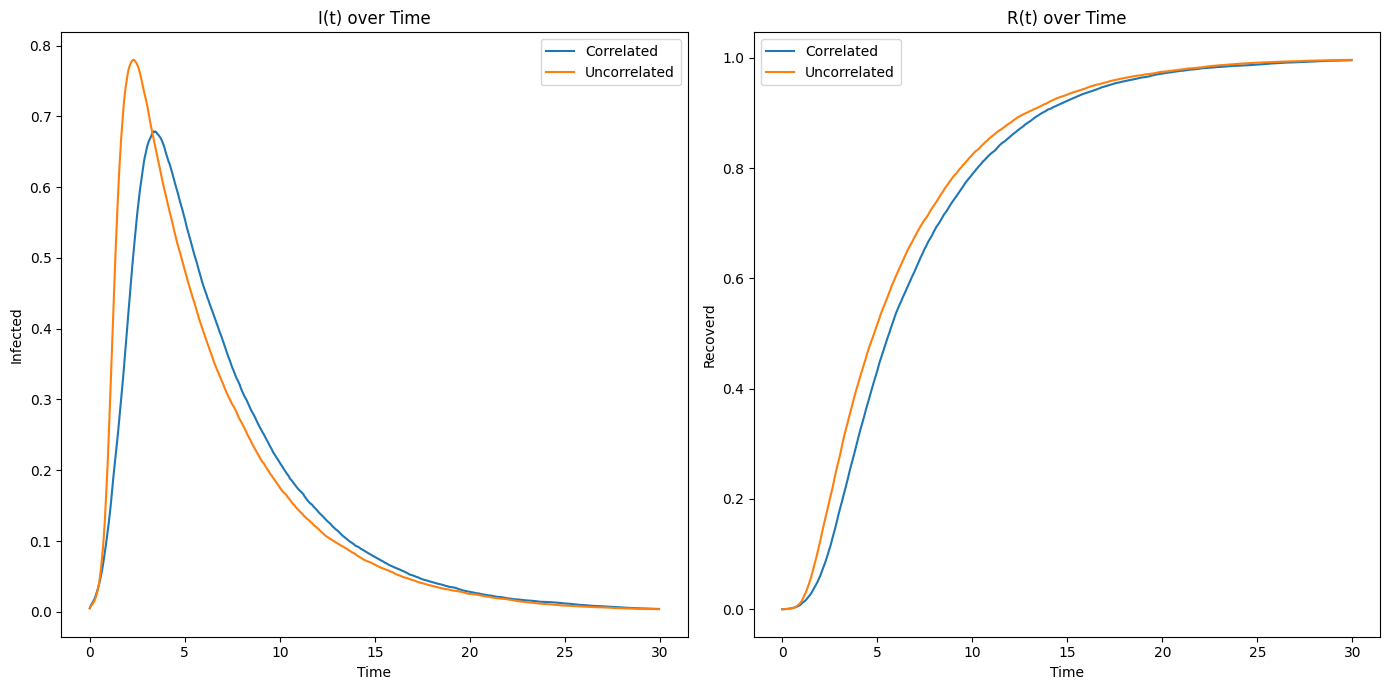

In [53]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(t_bins, I_averages_nmi1/N, label='Correlated')
plt.plot(t_bins, I_averages_nmi0/N, label='Uncorrelated')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.title('I(t) over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t_bins, R_averages_nmi1/N, label='Correlated')
plt.plot(t_bins, R_averages_nmi0/N, label='Uncorrelated')

plt.xlabel('Time')
plt.ylabel('Recoverd')
plt.title('R(t) over Time')
plt.legend()

plt.tight_layout()
plt.show()